In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer

**Цель работы:** изучить применимость алгоритмов LDA, QDA и pLSA на выбранном датасете  
**Задачи:**
- анализ применимости алгоритмов на основе структуры данных и требований алгоримтмов
- применение алгоритмов на выбранном датасете если возможно
- анализ остальных методов на иных датасетах

### Теоритическая справка LDA

**1. Среднее класса $\mu_i$** — это среднее арифметическое всех объектов $x_j$, относящихся к классу $Y_i$:

$$
\mu_i = \frac{1}{n_i} \sum_{j: y_j = Y_i} x_j,
$$

где $n_i$ — число объектов этого класса.

**2. Ковариационная матрица класса $\Sigma_i$** вычисляется как выборочная ковариация признаков внутри класса:

$$
\Sigma_i = \frac{1}{n_i - 1} \sum_{j: y_j = Y_i} (x_j - \mu_i)(x_j - \mu_i)^T.
$$

Это матрица, отражающая дисперсию и взаимосвязь признаков внутри класса.

**3. Объединенная (pooled) ковариационная матрица $\Sigma$** — это взвешенное среднее ковариационных матриц всех классов:

$$
\Sigma = \sum_{i=1}^K \frac{(n_i - 1)}{n - K}\Sigma_i,
$$

где $K$ — число классов. Такая объединенная матрица используется в LDA для построения одного общего ковариационного оценивания, предполагающего одинаковые ковариации для всех классов.

**4. Плотность распределения**  
Предполагаем, что классы имеют нормальное распределение с одинаковой ковариационной матрицей. Тогда плотность в точке $x$:

$$
p_i(x) = p(x|\xi = Y_i) = \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (x-\mu_i)^T \Sigma^{-1} (x-\mu_i) \right),
$$

и классифицирующая функция

$$
f_i(x) = \pi_i p(x|\xi = Y_i),
$$

где $\pi_i$ — априорная вероятность наблюдения попасть в i-ю группу.

Для упрощения вычислений можно переписать классифицирующую функцию через возрастающее монотонное преобразование как:

$$
g_i(x) = \log f_i(x) = \log \pi_i - \frac{1}{2} \log |\Sigma| - \frac{1}{2} (x - \mu_i)^T \Sigma^{-1} (x - \mu_i).
$$

Сократив часть, не зависящую от номера класса, получаем линейные классифицирующие функции:

$$
 h_i(x) = -\frac{1}{2} \mu_i^T \Sigma^{-1} \mu_i + \mu_i^T \Sigma^{-1} x + \log \pi_i.
$$

**5. Снижение размерности**  
Важно, что в задаче классификации с $K$ классами векторы средних $\boldsymbol{\mu}_k$ лежат в аффинном подпространстве размерности не выше $K-1$. 

LDA снижает размерность, проецируя данные из исходного $d$-мерного пространства на подпространство размерности $\leq K-1$, которое оптимально разделяет классы, максимизируя дисперсию между классами относительно дисперсии внутри классов. 

Математически это достигается поиском собственных векторов решения задачи:

$$
S_W^{-1} S_B \mathbf{w} = \lambda \mathbf{w},
$$

где $S_W$ — ковариационная матрица разброса внутри классов, $S_B$ — ковариационная матрица разброса между средними классами.

Собственные векторы $\mathbf{w}$ с наибольшими собственными значениями $\lambda$ образуют дискриминантные оси, на которые проецируют исходные данные для наилучшего разделения классов.

Таким образом, LDA неявно делает и классификацию, и уменьшение размерности, сохраняя в новой подпространственной репрезентации максимум информации для различения классов.


### Теоритическая справка QDA

Предполагаем, что каждый класс имеет многомерное нормальное распределение с различными ковариационными матрицами. Тогда плотность в точке $x$ выражается как:

$$
 p(x|\xi = Y_i) = \frac{1}{(2\pi)^{p/2} |\Sigma_i|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu_i)^T \Sigma_i^{-1} (x - \mu_i) \right),
$$

и классифицирующая функция $f_i(x) = \pi_i p(x|\xi = Y_i)$. Применяя возрастающее монотонное преобразование (логарифм) и оставляя в классифицирующей функции только члены, которые отличаются в разных группах, получаем:

$$
 g_i(x) = \log f_i(x) = \log \pi_i - \frac{1}{2} \log |\Sigma_i| - \frac{1}{2} (x - \mu_i)^T \Sigma_i^{-1} (x - \mu_i),
$$

что даёт квадратично зависящую от $x$ классифицирующую функцию.

**Основные отличия от LDA:**
- В LDA предполагается, что все классы имеют одинаковую ковариационную матрицу $\Sigma$, приводя к линейным решающим поверхностям.
- В QDA каждый класс обладает своей ковариационной матрицей $\Sigma_i$, из-за чего границы решения становятся квадратичными (например, эллиптическими).

### Теоретическая справка pLSA

pLSA (probabilistic latent semantic analysis), она же pLSI (probabilistic latent semantic indexing) — вероятностный латентно-семантический анализ (индексирование). Модель предложена в 1999 г. Томасом
Хоффманом.

**Дана** коллекция текстовых документов (мешок слов): $n_{dω}$ — сколько раз термин ω встречается в документе d.  
**Найти** модель $p(ω|d) = P(ω|t, θ, φ)$ с параметрами $φ$, $θ$:  
- $φ_{ωt} = p(ω|t)$ — вероятности терминов ω в каждой теме t;  
- $θ_{td} = p(t|d)$ — вероятности тем t в каждом документе d.  


Неизвестная модель находится путем максимизации логарифма правдоподобия:  
$∑_{d, ω} n_{d,ω} ln ∑_{t} φ_{ωt} θ_{td} → max$  
при ограничениях нормировки и неотрицательности:  
$$
φ_{ωt} ≥ 0;  ∑_{ω} φ_{ωt} = 1;  
θ_{td} ≥ 0;  ∑_{t} θ_{td} = 1  
$$
Точка максимума правдоподобия $φ, θ$ удовлетворяет системе уравнений со вспомогательными переменными $p_{tdω}$:  

$$
\begin{cases}
p_{tdω} = \frac{φ_{ωt} θ_{td}}{\sum_{t'} φ_{ωt'} θ_{t'd}} \\
φ_{ωt} = \frac{n_{ωt}}{\sum_{ω'} n_{ω't}}, \quad n_{ωt} = \sum_{d \in D} n_{dω} p_{tdω} \\
θ_{td} = \frac{n_{td}}{\sum_{t'} n_{t'd}}, \quad n_{td} = \sum_{ω \in d} n_{dω} p_{tdω}
\end{cases}
$$

Где первое уравнение — это E-шаг EM-алгоритма, а второе и третье — M-шаг.

**Перплексия (perplexity)** — это распространённая метрика качества тематических моделей, включая pLSA. Она измеряет, насколько хорошо модель предсказывает наблюдаемые слова в документах: чем ниже перплексия, тем лучше модель.

Для pLSA перплексия рассчитывается через логарифм правдоподобия модели:

$$
\text{Perplexity}(D) = \exp \left( - \frac{1}{N} \sum_{d \in D} \sum_{w \in d} n_{dw} \log p(w|d) \right),
$$

где

- $D$ — множество документов,
- $n_{dw}$ — количество вхождений слова $w$ в документ $d$,
- $p(w|d)$ — вероятность слова $w$ в документе $d$ по модели (считается из параметров pLSA),
- $N = \sum_{d \in D} \sum_{w \in d} n_{dw}$ — общее число слов во всех документах.

### Предположение о работе методов на датасете из ДЗ 1-2

На моем датасете метод pLSA не применим, потому что  
1. датасет состоит в большей степени из числовых и булевых признаков, которые при переводе в токены не будут иметь понятной интерпретации
2. датасет представляет собой характеристики и стоимость б/у автомобилей и выделение тем на таких данных бессмысленно
3. можно было бы попытаться выделять темы согласно классам, например, стоимости, но из-за большого количества признаков и сложных зависимостей, темы будет сложно определить по вошедшим в них токенам

Рассмотрим методы LDA и QDA для моего датасета.
Метод LDA может дать неплохие предсказания так как в данных есть числовые признаки нормально распределенные для всех классов, например, пробег или объем двигателя. На таких признаках ковариационные матрицы могут иметь схожие значения. А так же значения для булевых признаках в ковариационных матрицах будут иметь одинаково низкие значения.  

При этом метод QDA, возможно, будет чуть лучше для данной задачи, т.к. есть признаки которые имеют разные распрделения по классам, например, год производства. Этот метод способен учесть такие зависимости. 

## Использование методов LDA и QDA на датасете из ДЗ 1-2

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')
y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)
labels_y = ['low', 'mid-', 'mid', 'mid+', 'high']

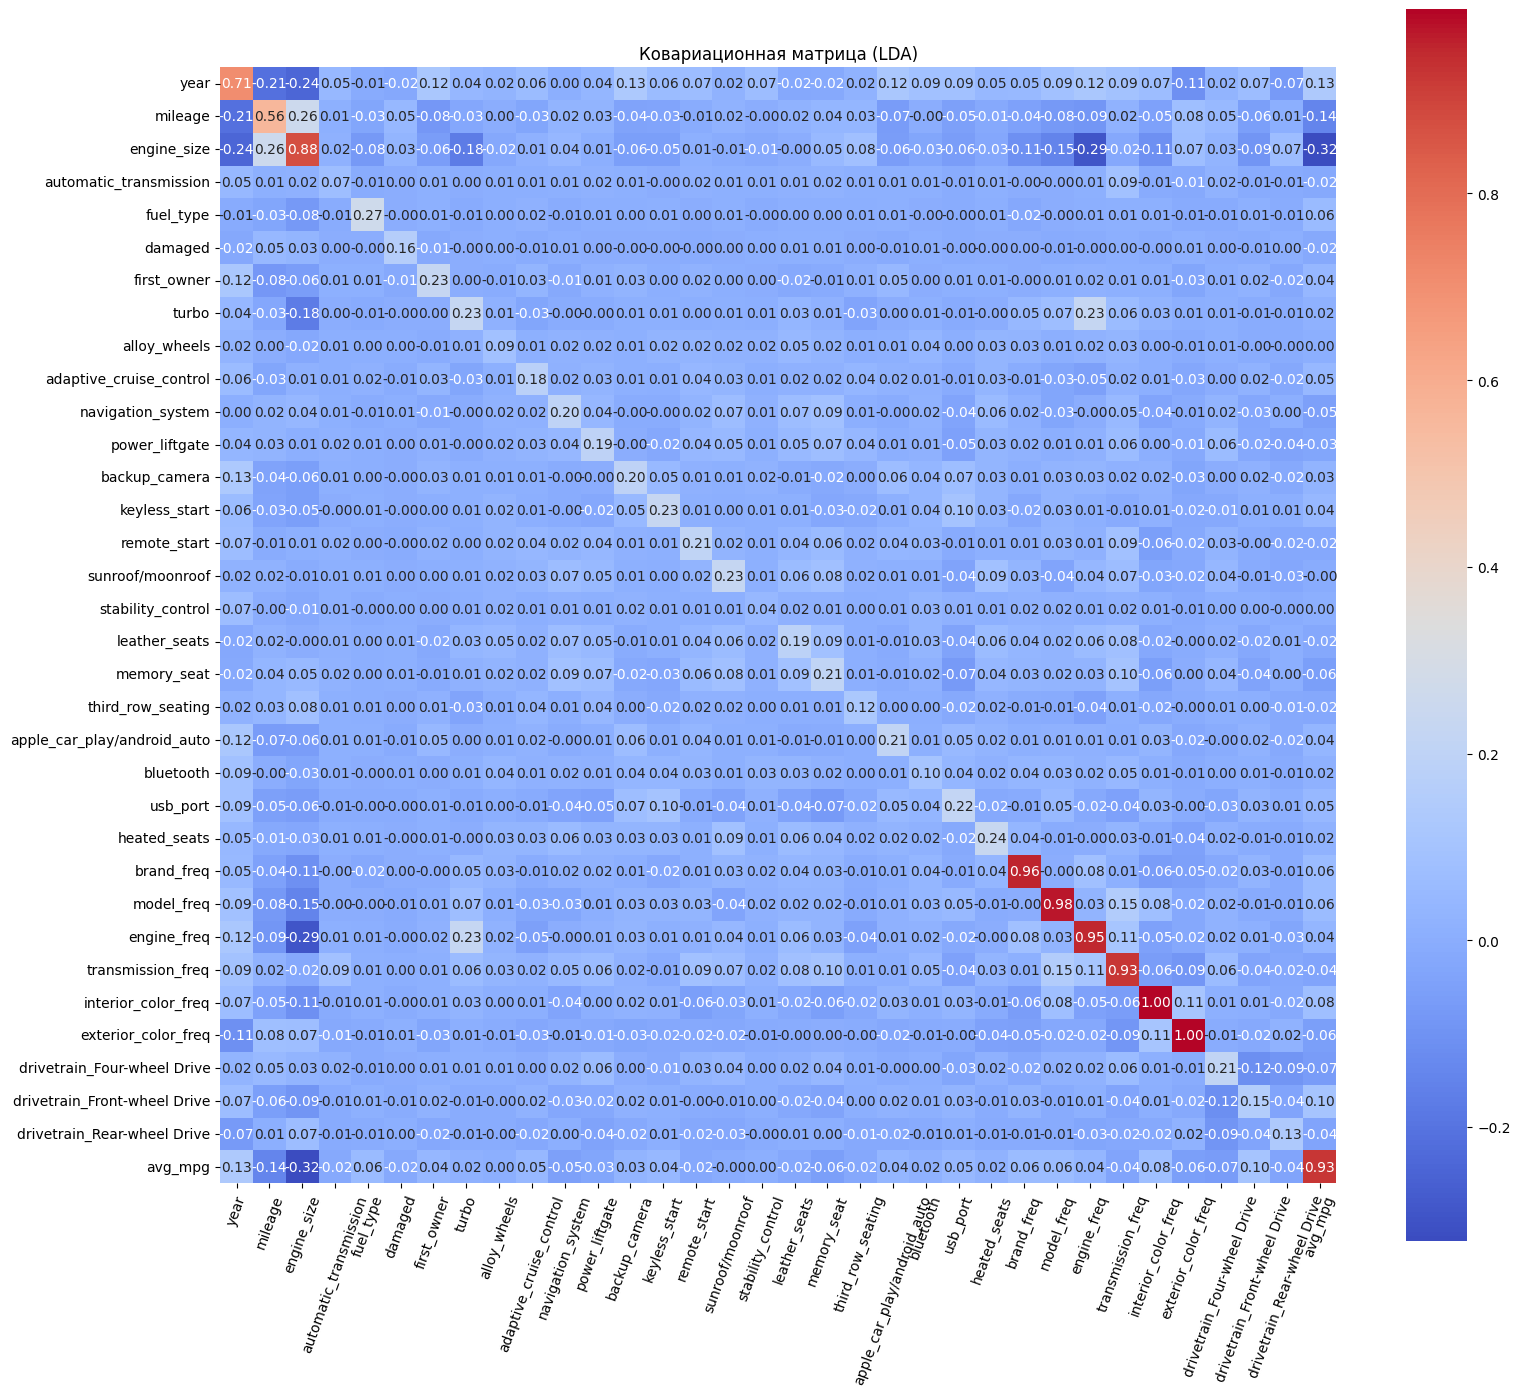

In [3]:
lda = LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True) # по умолчанию solver='svd', но при сингулярном разложении ковариационная матрица не сохраняется
lda.fit(X_train, y_train)

covariance_matrix = lda.covariance_
columns_labels = X_train.columns

cov_df = pd.DataFrame(covariance_matrix, index=columns_labels, columns=columns_labels)

plt.figure(figsize=(18, 16))
sns.heatmap(cov_df, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=70)
plt.title('Ковариационная матрица (LDA)')
plt.show()


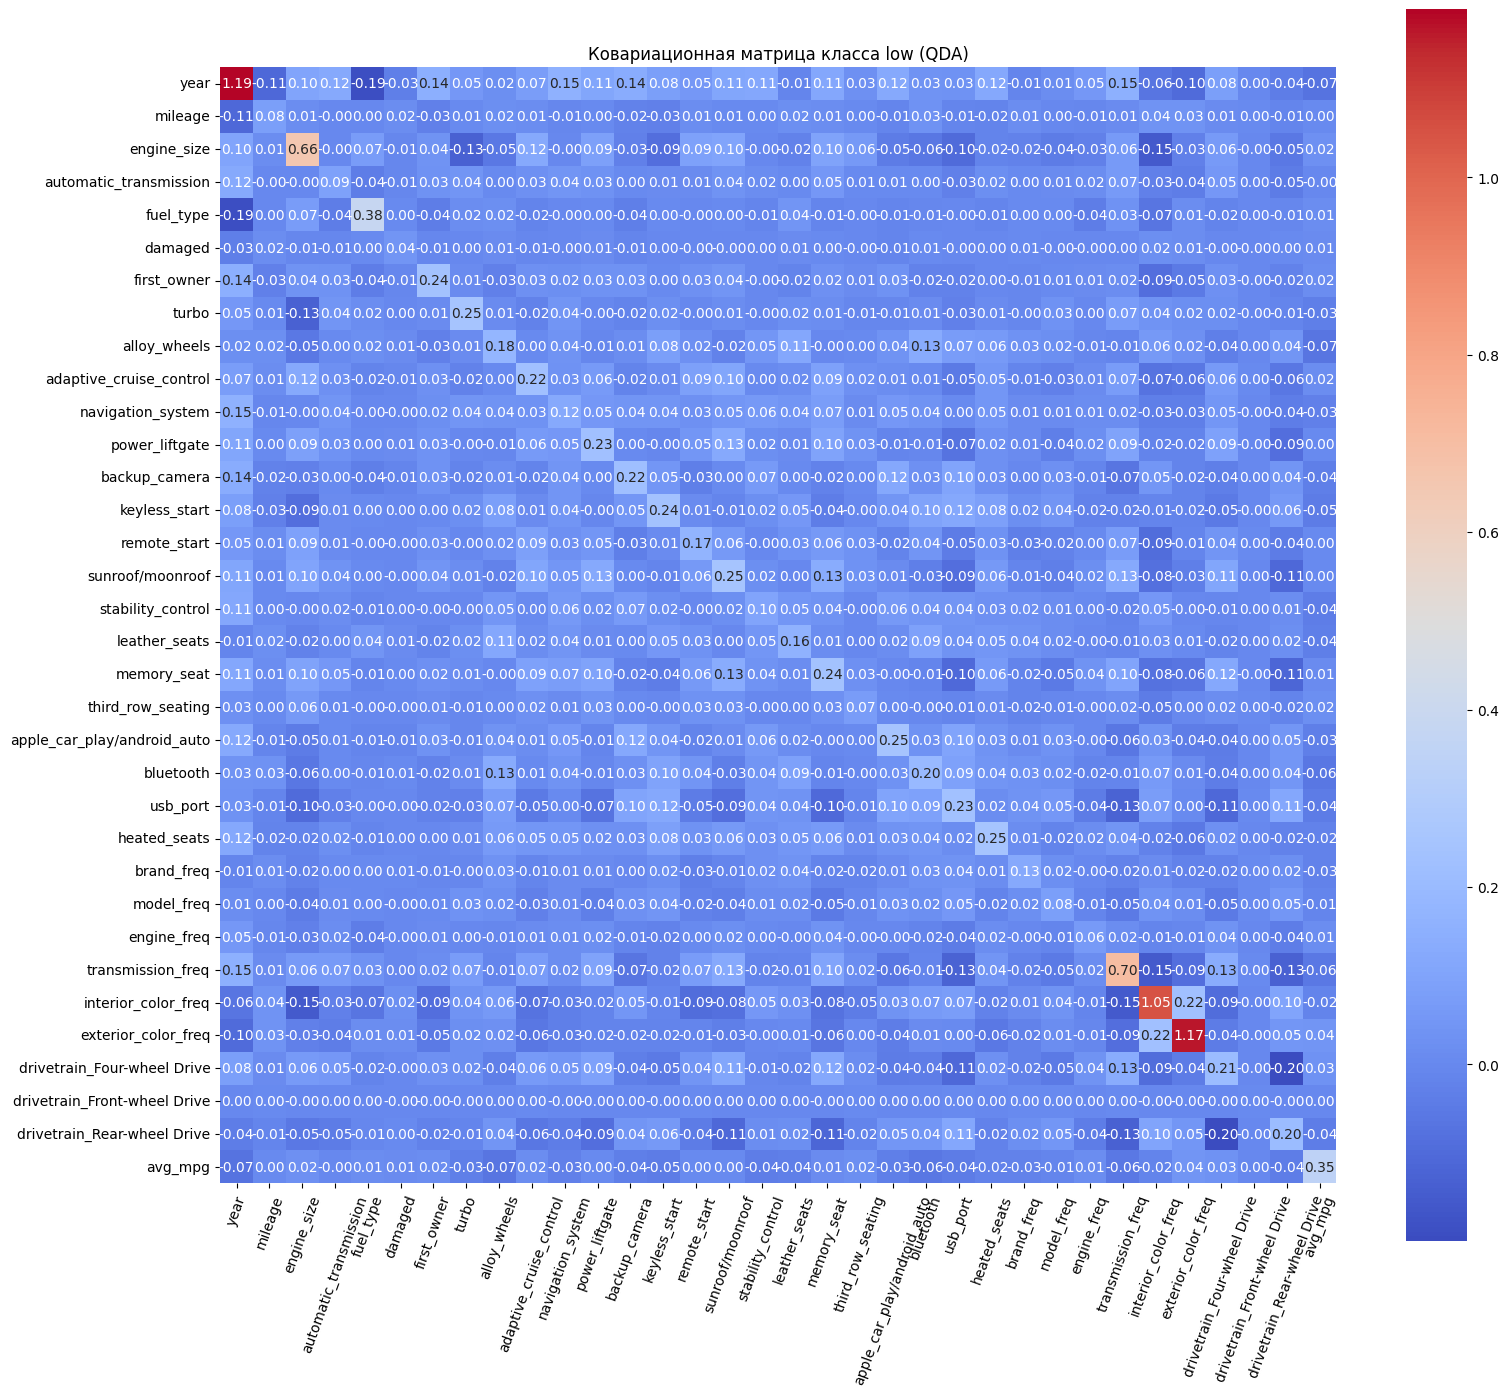

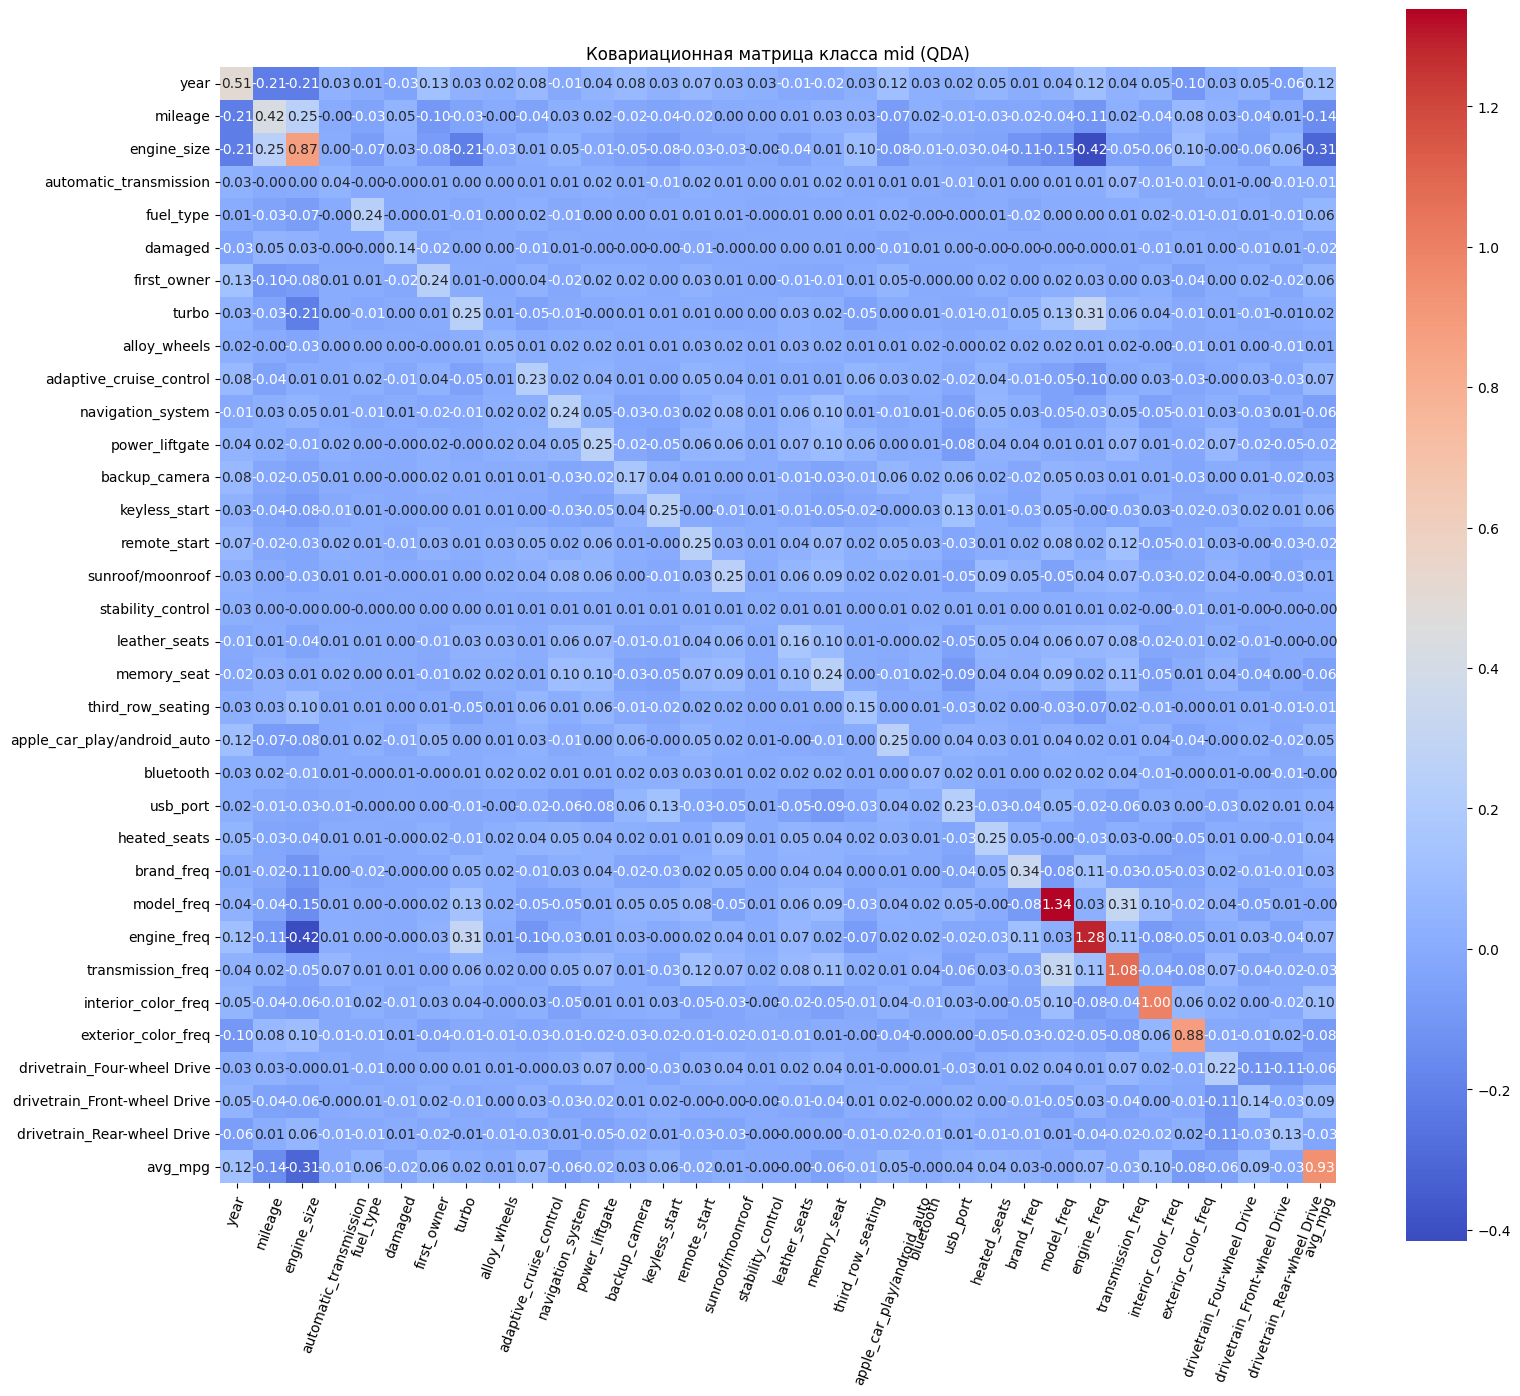

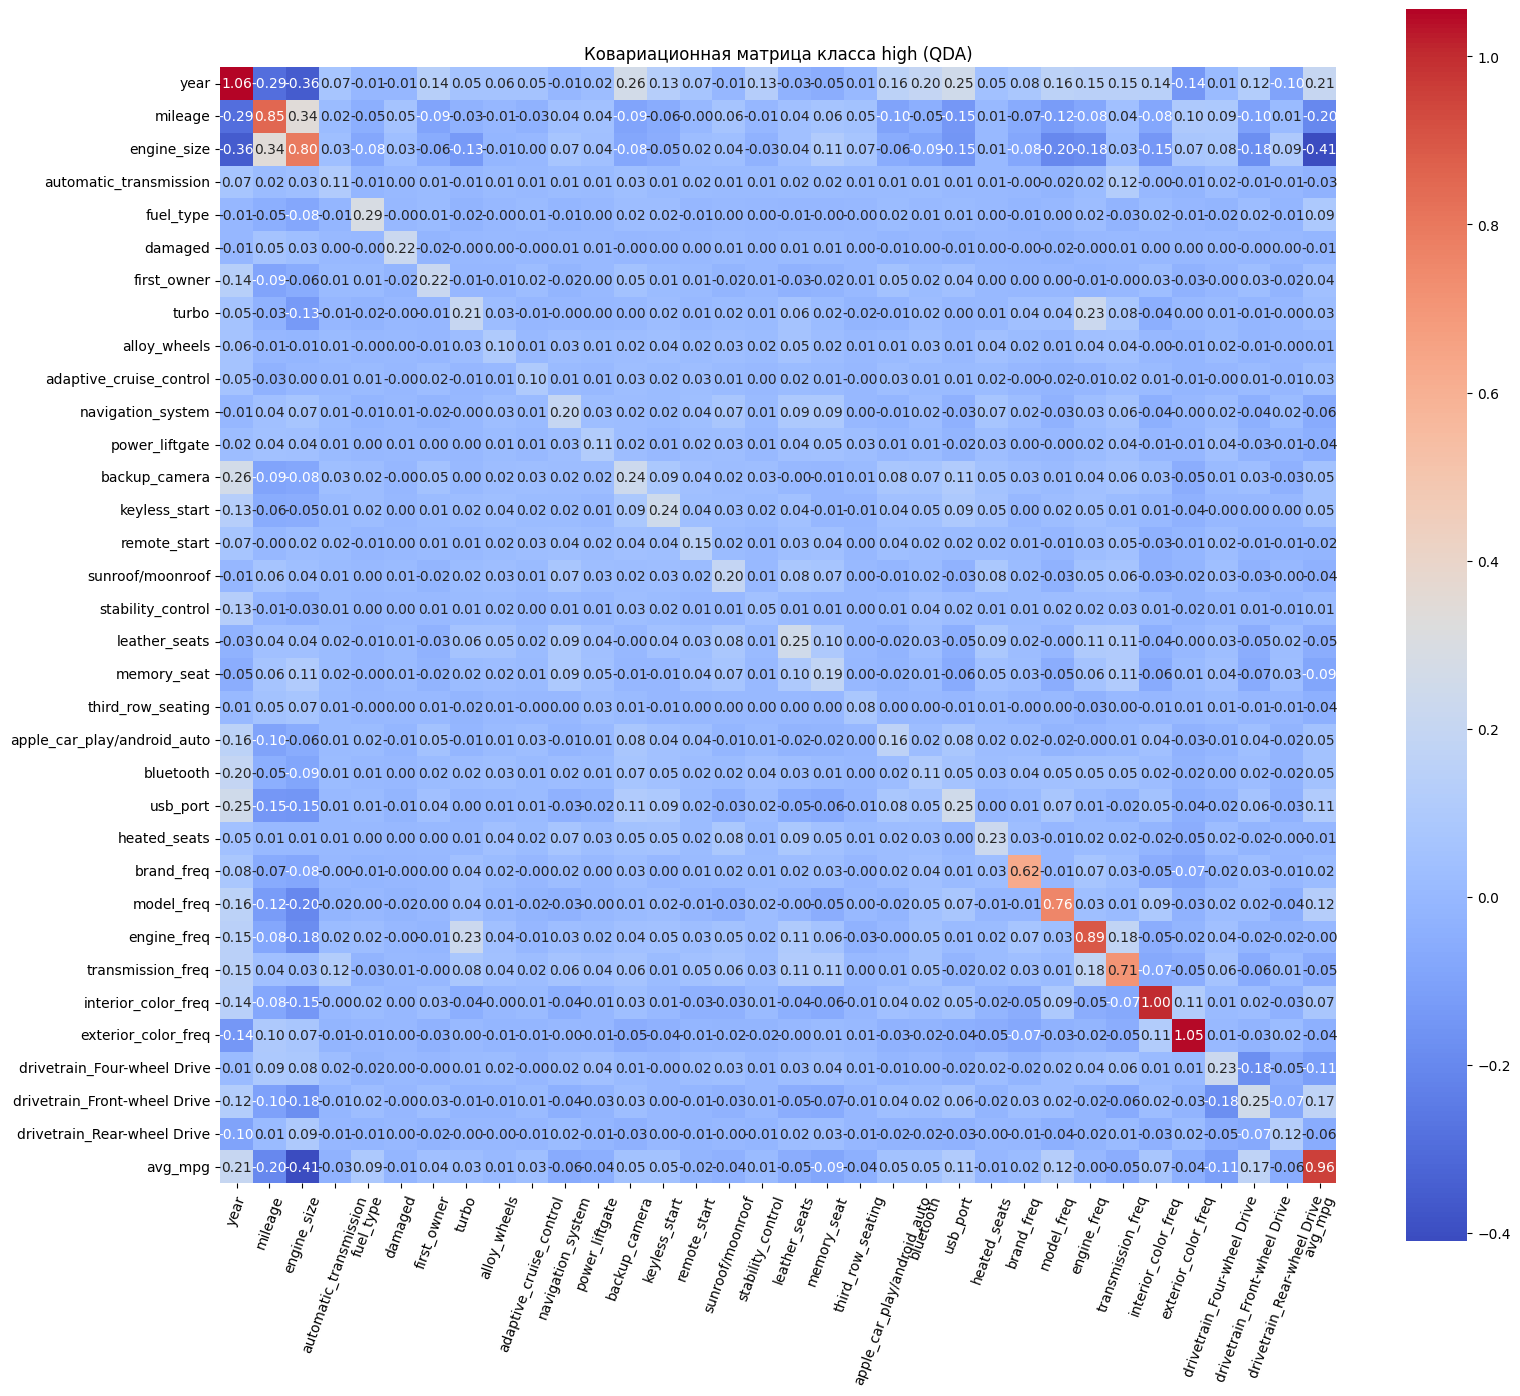

In [4]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)

for i, cov_matrix in enumerate(qda.covariance_):
    cov_df = pd.DataFrame(cov_matrix, index=columns_labels, columns=columns_labels)
    plt.figure(figsize=(18, 16))
    sns.heatmap(cov_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f'Ковариационная матрица класса {labels_y[i]} (QDA)')
    plt.xticks(rotation=70)
    plt.show()

Видим, что ковариационные матрицы классов не одинаковы, однако есть множество близких значений. На этом этапе можно предположить, что оба метода будут неплохо справляться с задачей

In [5]:
y_pred_lda = lda.predict(X_test)
y_pred_qda = qda.predict(X_test)

acc_lda = accuracy_score(y_test, y_pred_lda)
acc_qda = accuracy_score(y_test, y_pred_qda)

print(f'Accuracy LDA: {acc_lda:.4f}')
print(f'Accuracy QDA: {acc_qda:.4f}')

Accuracy LDA: 0.7292
Accuracy QDA: 0.6654


Для более детального анализа рассмотрим матрицы ошибок

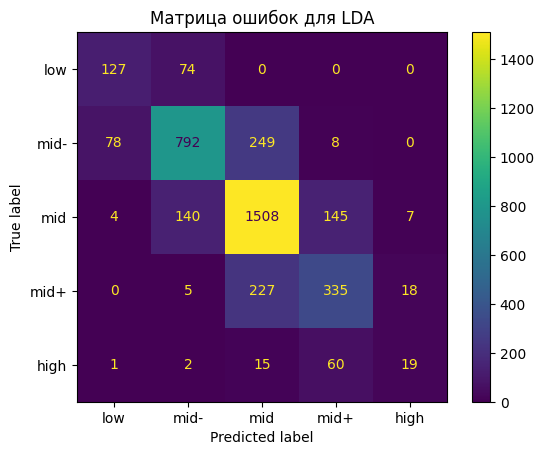

In [6]:
lda_cm = confusion_matrix(y_test, y_pred_lda, labels=labels_y)
lda_cm = ConfusionMatrixDisplay(confusion_matrix=lda_cm, display_labels=labels_y)
lda_cm.plot()
plt.title('Матрица ошибок для LDA')
plt.show()

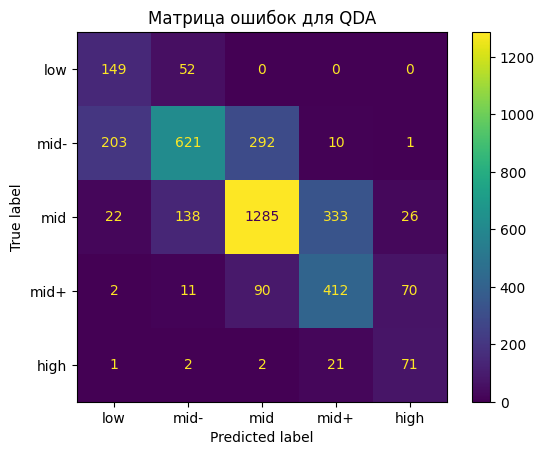

In [7]:
qda_cm = confusion_matrix(y_test, y_pred_qda, labels=labels_y)
qda_cm = ConfusionMatrixDisplay(confusion_matrix=qda_cm, display_labels=labels_y)
qda_cm.plot()
plt.title('Матрица ошибок для QDA')
plt.show()

#### Вывод: 
Видим, что у QDA accuracy ниже, но при этом на матрице ошибок видно, что для "граничных" классов low, high точность QDA выше, чем у LDA. В контексте задачи это говорит о том что QDA лучше подходит для классификации.  

Такие результаты связаны с дисбарансом классов. LDA лучше справляется с классификацией на тех классах для которых количество экземпляров больше, так как их ковариационная матрица имеет большее влияние. QDA метод для всех классов имеет схожий процент верных предсказаний. Это напоминает использование параметра `lass_weight='balanced'` из ДЗ2, где при подборе параметров более высокую общую метрику давало значение `None`, но при значении `balanced` результаты были лучше для данной задачи.

## Использование метода pLSA на другом датасете

Датасет [Ecommerce Text Classification](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification/data)

Это основанный на классификации набор текстовых данных электронной коммерции по 4 категориям — «Электроника», «Товары для дома», «Книги» и «Одежда и аксессуары».

Набор данных представлен в формате CSV и состоит из двух столбцов: 
- имя класса 
- товар и его описание с сайта электронной коммерции. 

In [8]:
df = pd.read_csv('data/ecommerceDataset.csv', header=None)
df.columns = ['theme', 'text']
df['theme'] = df['theme'].astype('category')
df['text'] = df['text'].astype('string')
df

theme                                               text
0        Household  Paper Plane Design Framed Wall Hanging Motivat...
1        Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2        Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3        Household  SAF Flower Print Framed Painting (Synthetic, 1...
4        Household  Incredible Gifts India Wooden Happy Birthday U...
...            ...                                                ...
50420  Electronics  Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421  Electronics  CrossBeats Wave Waterproof Bluetooth Wireless ...
50422  Electronics  Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423  Electronics  Samsung Guru FM Plus (SM-B110E/D, Black) Colou...
50424  Electronics                   Micromax Canvas Win W121 (White)

[50425 rows x 2 columns]

In [9]:
filtered_df = df[df['text'].isna() | df['theme'].isna()]
filtered_df

theme  text
39330  Clothing & Accessories  <NA>

Датасет досатоточно большой из-за чего вычисление матричными методами требует слишком много оперативной памяти (без использования эвристик), поэтому оставим по 500 текстов каждого класса.

In [10]:
df = df.dropna(subset=['text'], how='all')
df = df.groupby('theme', observed=False).head(500).reset_index(drop=True)
df['theme'].unique()

['Household', 'Books', 'Clothing & Accessories', 'Electronics']
Categories (4, object): ['Books', 'Clothing & Accessories', 'Electronics', 'Household']

Распишем вычисление pLSA с помощью EM алгоритма (44-й слайд [презентации](https://drive.google.com/file/d/1wv7rXv4feY7ePpsA0wPOtuZuPV3DrACB/view)) и функцию вычисления perplexity по описанию из справки

In [11]:
def pLSA(D, n_topics, imax):
    """
    Вход:
    D (n_docs, n_terms): частоты слов по документам
    n_topics: число тем |T|
    imax: число итераций EM
    
    Выход:
    phi (n_terms, n_topics): термы по темам
    theta (n_topics, n_docs): темы по документам
    """
    n_docs, n_terms  = D.shape
    
    phi = np.random.rand(n_terms, n_topics)
    phi /= phi.sum(axis=0, keepdims=True)
    theta = np.random.rand(n_topics, n_docs)
    theta /= theta.sum(axis=0, keepdims=True)
    
    for _ in range(imax):
        n_wt = np.zeros((n_terms, n_topics))
        n_td = np.zeros((n_topics, n_docs))
        n_t = np.zeros(n_topics)
        n_d = np.zeros(n_docs)
        
        for d in range(n_docs):
            for w in range(n_terms):
                if D[d, w] == 0:
                    continue

                denominator = np.sum(phi[w, :] * theta[:, d])

                if denominator == 0:
                    continue

                for t in range(n_topics):
                    p_t_d_w = (phi[w, t] * theta[t, d]) / denominator
                    count = D[d, w] * p_t_d_w
                    n_wt[w, t] += count
                    n_td[t, d] += count
                    n_t[t] += count
                    n_d[d] += count
        
        for t in range(n_topics):
            if n_t[t] != 0:
                phi[:, t] = n_wt[:, t] / n_t[t]
        
        for d in range(n_docs):
            if n_d[d] != 0:
                theta[:, d] = n_td[:, d] / n_d[d]
                
    return phi, theta


In [12]:
def calculate_perplexity(D, phi, theta):
    """
    D: (n_terms, n_docs) - n_{dw} (матрица транспонирваная)
    phi: (n_terms, n_topics) - P(w|t)
    theta: (n_topics, n_docs) - P(t|d)
    """
    total_words = D.sum()
    Pw_d = phi @ theta  # (n_terms x n_docs)
    Pw_d = np.clip(Pw_d, 1e-12, None) # это для устойчивости
    log_likelihood = np.sum(D * np.log(Pw_d))
    perplexity = np.exp(-log_likelihood / total_words)
    return perplexity

Проводился запуск без нормализации, но значения perplexity получались от 2200, поэтому добавим леммантизацию (стэмминг было бы быстрее, но менее точно и слова в темах будет сложнее интерпретировать). Стоп слова будем фильтровать непосредственно в CountVectorizer.

Также были попытки применить токенизатор WordPunctTokenizer но встроенный в CountVectorizer показывает меньшую размерность, поэтому использую его.

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preproces(text):
    spacy_results = nlp(text)
    spacy_results = [token.lemma_ for token in spacy_results if not token.is_punct]
    spacy_results = ' '.join(spacy_results)
    return spacy_results

In [14]:
df['text'] = df['text'].apply(preproces)
df['text'] = df['theme'].astype('string') + ' ' + df['text']
df

theme                                               text
0       Household  Household Paper Plane Design Framed Wall Hangi...
1       Household  Household SAF Floral Framed Painting Wood 30 i...
2       Household  Household SAF UV Textured Modern Art Print Fra...
3       Household  Household SAF Flower Print Framed Painting Syn...
4       Household  Household Incredible Gifts India Wooden Happy ...
...           ...                                                ...
1995  Electronics  Electronics Lapcare HP Pavilion DV4 DV5 series...
1996  Electronics  Electronics Dell inspiron series 6cell battery...
1997  Electronics  Electronics Lapkit Replacement Long Life Noteb...
1998  Electronics  Electronics lapcare 19v 3.16Amp 60 W Laptop Ad...
1999  Electronics  Electronics lapcare 19v 3.16Amp 60 W Laptop Ad...

[2000 rows x 2 columns]

In [15]:
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
D = vectorizer.fit_transform(df['text'])
D = D.toarray()
D.shape

(2000, 11848)

In [16]:
n_topics = 4
imax = 50
phi, theta = pLSA(D, n_topics, imax)
perplexity_4 = calculate_perplexity(D.T, phi, theta)

In [17]:
terms = vectorizer.get_feature_names_out()
for t in range(n_topics):
    print(f"Тема {t+1}:")
    top_terms_idx = phi[:, t].argsort()[-10:]
    top_terms = [terms[i] for i in top_terms_idx]
    print(top_terms)

Тема 1:
['clay', 'read', 'work', 'review', 'new', 'life', 'world', 'author', 'books', 'book']
Тема 2:
['household', 'boys', 'wear', 'design', 'color', 'baby', 'set', 'accessories', 'make', 'clothing']
Тема 3:
['use', 'disk', 'make', 'household', 'case', 'inch', 'size', 'cm', 'drive', 'hard']
Тема 4:
['mm', 'wireless', 'port', 'keyboard', 'use', 'laptop', 'design', 'electronics', 'cable', 'usb']


Знаем что у нас тексты классифицируются на 4 класса. Из этих слов можно предположить что Тема 1 сравнима с классом `Books`, Темы 2 и 3 либо `Clothing & Accessories`, либо `Household`, Тема 4 с `Electronics`

Попробуем взять количество тем как меньше так и больше чем количестов классов

In [18]:
perplexities = []

for n_topics in range(1, 7):
    if n_topics == 4:
        perplexities.append(perplexity_4)
        continue
    phi, theta = pLSA(D, n_topics, imax)
    perplexity = calculate_perplexity(D.T, phi, theta)
    perplexities.append(perplexity)

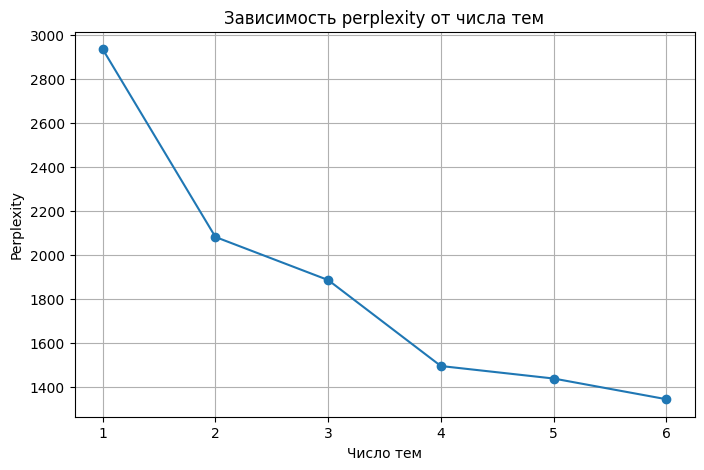

In [19]:
num_topics_range = range(1, 7)

plt.figure(figsize=(8, 5))
plt.plot(num_topics_range, perplexities, marker='o')
plt.title("Зависимость perplexity от числа тем")
plt.xlabel("Число тем")
plt.ylabel("Perplexity")
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

Видим, что значение perplexity стремительно снижается, поэтому продолжим увеличивать количество тем, чтобы узнать какое число будет оптимальным.

In [20]:
for n_topics in range(7, 11):
    phi, theta = pLSA(D, n_topics, imax)
    perplexity = calculate_perplexity(D.T, phi, theta)
    perplexities.append(perplexity)

In [21]:
num_topics_range = range(1, 11)

plt.figure(figsize=(8, 5))
plt.plot(num_topics_range, perplexities, marker='o')
plt.title("Зависимость perplexity от числа тем")
plt.xlabel("Число тем")
plt.ylabel("Perplexity")
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

**Вывод:**
Метрика perplexity стремительно убывает до количества тем 4, а после снижение "замедляется". Это согласуется с количеством классов. Так как данные содержат описание товаров, а не полноценные тексты, то значение метрик достаточно высокое и для 4 тем интерпретировать по классам сложно.